In [1]:
%matplotlib inline

In [2]:
# -*- coding: utf-8 -*-
"""
@author: Hiromasa Kaneko
課題16: logSdataset1290.csvを読み込み、1番目から878番目までのサンプルをトレーニングデータとし、残りをテストデータとして、
PLS・リッジ回帰・LASSO・Elastic net・SVR(線形カーネル)・SVR(ガウシアンカーネル)・ランダムフォレストモデルをそれぞれ
作成し、テストデータの予測を行え。クロスバリデーションは5-fold クロスバリデーションとする。
説明変数も目的変数もオートスケーリングを行うこと。すべてのモデルにおいて、トレーニングデータとテストデータそれぞれに
対して、実測値と計算値もしくは予測値との間でr2, RMSE, MEAを計算し、実測値と計算値もしくは予測値とのプロットを作成せよ。
モデル間で結果を比較し、考察せよ。
"""

import math

import matplotlib.figure as figure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import model_selection, svm
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, ElasticNetCV
from sklearn.model_selection import GridSearchCV


In [3]:
regression_method_flag = 3
# 1:OLS, 
# 2:PLS(constant component number), 
# 3:PLS, 
# 4:Ridge regression
# 5:LASSO, 
# 6:Elastic net, 
# 7:Linear SVR, 
# 8:Nonlinear SVR, 
# 9:Random forest

number_of_training_data = 878  # if this is the number of all samples, there are no test samples.
do_autoscaling = True  # True or False
threshold_of_rate_of_same_value = 0.79

fold_number = 2
pls_component_number = 2
max_pls_component_number = 50

ridge_lambdas = 2 ** np.arange(-5, 10, dtype=float)  # L2 weight in ridge regression

lasso_lambdas = np.arange(0.01, 0.71, 0.01, dtype=float)  # L1 weight in LASSO

elastic_net_lambdas = np.arange(0.01, 0.71, 0.01, dtype=float)  # Lambda in elastic net
elastic_net_alphas = np.arange(0.01, 1.00, 0.01, dtype=float)  # Alpha in elastic net

linear_svr_cs = 2 ** np.arange(-5, 5, dtype=float)  # C for linear svr
linear_svr_epsilons = 2 ** np.arange(-10, 0, dtype=float)  # Epsilon for linear svr

nonlinear_svr_cs = 2 ** np.arange(-5, 10, dtype=float)  # C for nonlinear svr
nonlinear_svr_epsilons = 2 ** np.arange(-10, 0, dtype=float)  # Epsilon for nonlinear svr
nonlinear_svr_gammas = 2 ** np.arange(-20, 10, dtype=float)  # Gamma for nonlinear svr

random_forest_number_of_trees = 300  # Number of decision trees for random forest
random_forest_x_variables_rates = np.arange(1, 10,
                                            dtype=float) / 10  # Ratio of the number of X-variables for random forest


In [4]:
# load data set
raw_data_with_y = pd.read_csv('logSdataset1290.csv', encoding='SHIFT-JIS', index_col=0)

raw_data_with_y = raw_data_with_y.loc[:, raw_data_with_y.mean().index]  # 平均を計算できる変数だけ選択

# raw_data_with_y = raw_data_with_y.loc[raw_data_with_y.mean(axis=1).index,:] #平均を計算できるサンプルだけ選択

raw_data_with_y = raw_data_with_y.replace(np.inf, np.nan).fillna(np.nan)  # infをnanに置き換えておく

raw_data_with_y = raw_data_with_y.dropna(axis=1)  # nanのある変数を削除

# raw_data_with_y = raw_data_with_y.dropna() #nanのあるサンプルを削除

# logSdataset1290.csv用 変数選択により精度向上
raw_data_with_y = raw_data_with_y.drop(['Ipc', 'Kappa3'], axis=1)  # Ipc:1139だけ外れ値をもつ記述子、Kappa3:889だけ外れ値をもつ記述子

# delete duplicates
# raw_data_with_y = raw_data_with_y.loc[~raw_data_with_y.index.duplicated(keep='first'),:] #重複したサンプルの最初を残す
# raw_data_with_y = raw_data_with_y.loc[~raw_data_with_y.index.duplicated(keep='last'),:] #重複したサンプルの最後を残す

raw_data_with_y = raw_data_with_y.loc[~raw_data_with_y.index.duplicated(keep=False), :]  # 重複したサンプルはすべて削除

ytrain = raw_data_with_y.iloc[:number_of_training_data, 0]
raw_Xtrain = raw_data_with_y.iloc[:number_of_training_data, 1:]
ytest = raw_data_with_y.iloc[number_of_training_data:, 0]
raw_Xtest = raw_data_with_y.iloc[number_of_training_data:, 1:]

# y = raw_data_with_y[raw_data_with_y.columns[0]]
# rawX = raw_data_with_y[raw_data_with_y.columns[1:]]
# rawX_tmp = rawX.copy()

# delete descriptors with high rate of the same values
rate_of_same_value = list()
num = 0

for X_variable_name in raw_Xtrain.columns:
    num += 1
    print('{0} / {1}'.format(num, raw_Xtrain.shape[1]))
    same_value_number = raw_Xtrain[X_variable_name].value_counts()
    rate_of_same_value.append(float(same_value_number[same_value_number.index[0]] / raw_Xtrain.shape[0]))
deleting_variable_numbers = np.where(np.array(rate_of_same_value) >= threshold_of_rate_of_same_value)

"""
# delete descriptors with zero variance
deleting_variable_numbers = np.where( raw_Xtrain.var() == 0 )
"""

if len(deleting_variable_numbers[0]) == 0:
    Xtrain = raw_Xtrain.copy()
    Xtest = raw_Xtest.copy()
else:
    Xtrain = raw_Xtrain.drop(raw_Xtrain.columns[deleting_variable_numbers], axis=1)
    Xtest = raw_Xtest.drop(raw_Xtest.columns[deleting_variable_numbers], axis=1)
    print('Variable numbers zero variance: {0}'.format(deleting_variable_numbers[0] + 1))

print('# of X-variables: {0}'.format(Xtrain.shape[1]))

1 / 194
2 / 194
3 / 194
4 / 194
5 / 194
6 / 194
7 / 194
8 / 194
9 / 194
10 / 194
11 / 194
12 / 194
13 / 194
14 / 194
15 / 194
16 / 194
17 / 194
18 / 194
19 / 194
20 / 194
21 / 194
22 / 194
23 / 194
24 / 194
25 / 194
26 / 194
27 / 194
28 / 194
29 / 194
30 / 194
31 / 194
32 / 194
33 / 194
34 / 194
35 / 194
36 / 194
37 / 194
38 / 194
39 / 194
40 / 194
41 / 194
42 / 194
43 / 194
44 / 194
45 / 194
46 / 194
47 / 194
48 / 194
49 / 194
50 / 194
51 / 194
52 / 194
53 / 194
54 / 194
55 / 194
56 / 194
57 / 194
58 / 194
59 / 194
60 / 194
61 / 194
62 / 194
63 / 194
64 / 194
65 / 194
66 / 194
67 / 194
68 / 194
69 / 194
70 / 194
71 / 194
72 / 194
73 / 194
74 / 194
75 / 194
76 / 194
77 / 194
78 / 194
79 / 194
80 / 194
81 / 194
82 / 194
83 / 194
84 / 194
85 / 194
86 / 194
87 / 194
88 / 194
89 / 194
90 / 194
91 / 194
92 / 194
93 / 194
94 / 194
95 / 194
96 / 194
97 / 194
98 / 194
99 / 194
100 / 194
101 / 194
102 / 194
103 / 194
104 / 194
105 / 194
106 / 194
107 / 194
108 / 194
109 / 194
110 / 194
111 / 19

In [5]:
# autoscaling
if do_autoscaling:
    autoscaled_Xtrain = (Xtrain - Xtrain.mean(axis=0)) / Xtrain.std(axis=0, ddof=1)
    autoscaled_ytrain = (ytrain - ytrain.mean()) / ytrain.std(ddof=1)
    autoscaled_Xtest = (Xtest - Xtrain.mean(axis=0)) / Xtrain.std(axis=0, ddof=1)
else:
    autoscaled_Xtrain = Xtrain.copy()
    autoscaled_ytrain = ytrain.copy()
    autoscaled_Xtest = Xtest.copy()


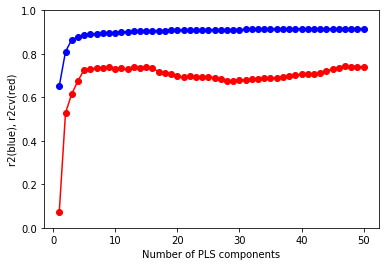

In [6]:
if regression_method_flag == 1:  # Ordinary Least Squares
    regression_model = LinearRegression()
    
elif regression_method_flag == 2:  # Partial Least Squares with constant component
    regression_model = PLSRegression(n_components=pls_component_number)

elif regression_method_flag == 3:  # Partial Least Squares
    pls_components = np.arange(1, min(np.linalg.matrix_rank(autoscaled_Xtrain) + 1, max_pls_component_number + 1), 1)
    r2all = list()
    r2cvall = list()
    for pls_component in pls_components:
        pls_model_in_cv = PLSRegression(n_components=pls_component)
        pls_model_in_cv.fit(autoscaled_Xtrain, autoscaled_ytrain)
        calculated_y_in_cv = np.ndarray.flatten(pls_model_in_cv.predict(autoscaled_Xtrain))
        estimated_y_in_cv = np.ndarray.flatten(
            model_selection.cross_val_predict(pls_model_in_cv, autoscaled_Xtrain, autoscaled_ytrain, cv=fold_number))
        if do_autoscaling:
            calculated_y_in_cv = calculated_y_in_cv * ytrain.std(ddof=1) + ytrain.mean()
            estimated_y_in_cv = estimated_y_in_cv * ytrain.std(ddof=1) + ytrain.mean()

        """
        plt.figure(figsize=figure.figaspect(1))
        plt.scatter( y, estimated_y_in_cv)
        plt.xlabel("Actual Y")
        plt.ylabel("Calculated Y")
        plt.show()
        """
        r2all.append(float(1 - sum((ytrain - calculated_y_in_cv) ** 2) / sum((ytrain - ytrain.mean()) ** 2)))
        r2cvall.append(float(1 - sum((ytrain - estimated_y_in_cv) ** 2) / sum((ytrain - ytrain.mean()) ** 2)))
        
    plt.plot(pls_components, r2all, 'bo-')
    plt.plot(pls_components, r2cvall, 'ro-')
    plt.ylim(0, 1)
    plt.xlabel('Number of PLS components')
    plt.ylabel('r2(blue), r2cv(red)')
    plt.show()
    optimal_pls_component_number = np.where(r2cvall == np.max(r2cvall))
    optimal_pls_component_number = optimal_pls_component_number[0][0] + 1
    regression_model = PLSRegression(n_components=optimal_pls_component_number)

elif regression_method_flag == 4:  # ridge regression
    r2cvall = list()
    for ridge_lambda in ridge_lambdas:
        rr_model_in_cv = Ridge(alpha=ridge_lambda)
        estimated_y_in_cv = model_selection.cross_val_predict(rr_model_in_cv, autoscaled_Xtrain, autoscaled_ytrain,
                                                              cv=fold_number)
        if do_autoscaling:
            estimated_y_in_cv = estimated_y_in_cv * ytrain.std(ddof=1) + ytrain.mean()
        r2cvall.append(float(1 - sum((ytrain - estimated_y_in_cv) ** 2) / sum((ytrain - ytrain.mean()) ** 2)))
    plt.figure()
    plt.plot(ridge_lambdas, r2cvall, 'k', linewidth=2)
    plt.xscale('log')
    plt.xlabel('Weight for ridge regression')
    plt.ylabel('r2cv for ridge regression')
    plt.show()
    optimal_ridge_lambda = ridge_lambdas[np.where(r2cvall == np.max(r2cvall))[0][0]]
    regression_model = Ridge(alpha=optimal_ridge_lambda)

elif regression_method_flag == 5:  # LASSO
    r2cvall = list()
    for lasso_lambda in lasso_lambdas:
        lasso_model_in_cv = Lasso(alpha=lasso_lambda)
        estimated_y_in_cv = model_selection.cross_val_predict(lasso_model_in_cv, autoscaled_Xtrain, autoscaled_ytrain,
                                                              cv=fold_number)
        if do_autoscaling:
            estimated_y_in_cv = estimated_y_in_cv * ytrain.std(ddof=1) + ytrain.mean()
        r2cvall.append(float(1 - sum((ytrain - estimated_y_in_cv) ** 2) / sum((ytrain - ytrain.mean()) ** 2)))
    plt.figure()
    plt.plot(lasso_lambdas, r2cvall, 'k', linewidth=2)
    plt.xlabel('Weight for LASSO')
    plt.ylabel('r2cv for LASSO')
    plt.show()
    optimal_lasso_lambda = lasso_lambdas[np.where(r2cvall == np.max(r2cvall))[0][0]]
    regression_model = Lasso(alpha=optimal_lasso_lambda)

elif regression_method_flag == 6:  # Elastic net
    elastic_net_in_cv = ElasticNetCV(cv=fold_number, l1_ratio=elastic_net_lambdas, alphas=elastic_net_alphas)
    elastic_net_in_cv.fit(autoscaled_Xtrain, autoscaled_ytrain)
    optimal_elastic_net_alpha = elastic_net_in_cv.alpha_
    optimal_elastic_net_lambda = elastic_net_in_cv.l1_ratio_
    regression_model = ElasticNet(l1_ratio=optimal_elastic_net_lambda, alpha=optimal_elastic_net_alpha)
    
elif regression_method_flag == 7:  # Linear SVR
    linear_svr_in_cv = GridSearchCV(svm.SVR(kernel='linear'), {'C': linear_svr_cs, 'epsilon': linear_svr_epsilons},
                                    cv=fold_number)
    linear_svr_in_cv.fit(autoscaled_Xtrain, autoscaled_ytrain)
    optimal_linear_svr_c = linear_svr_in_cv.best_params_['C']
    optimal_linear_svr_epsilon = linear_svr_in_cv.best_params_['epsilon']
    regression_model = svm.SVR(kernel='linear', C=optimal_linear_svr_c, epsilon=optimal_linear_svr_epsilon)

elif regression_method_flag == 8:  # Nonlinear SVR
    variance_of_gram_matrix = list()
    numpy_autoscaled_Xtrain = np.array(autoscaled_Xtrain)
    for nonlinear_svr_gamma in nonlinear_svr_gammas:
        gram_matrix = np.exp(
            -nonlinear_svr_gamma * ((numpy_autoscaled_Xtrain[:, np.newaxis] - numpy_autoscaled_Xtrain) ** 2).sum(
                axis=2))
        variance_of_gram_matrix.append(gram_matrix.var(ddof=1))
    optimal_nonlinear_gamma = nonlinear_svr_gammas[
        np.where(variance_of_gram_matrix == np.max(variance_of_gram_matrix))[0][0]]
    nonlinear_svr_in_cv = GridSearchCV(svm.SVR(kernel='rbf', gamma=optimal_nonlinear_gamma),
                                       {'C': nonlinear_svr_cs, 'epsilon': nonlinear_svr_epsilons}, cv=fold_number)
    nonlinear_svr_in_cv.fit(autoscaled_Xtrain, autoscaled_ytrain)
    optimal_nonlinear_c = nonlinear_svr_in_cv.best_params_['C']
    optimal_nonlinear_epsilon = nonlinear_svr_in_cv.best_params_['epsilon']
    regression_model = svm.SVR(kernel='rbf', C=optimal_nonlinear_c, epsilon=optimal_nonlinear_epsilon,
                               gamma=optimal_nonlinear_gamma)
    
elif regression_method_flag == 9:  # Random forest
    rmse_oob_all = list()
    for random_forest_x_variables_rate in random_forest_x_variables_rates:
        RandomForestResult = RandomForestRegressor(n_estimators=random_forest_number_of_trees, max_features=int(
            max(math.ceil(Xtrain.shape[1] * random_forest_x_variables_rate), 1)), oob_score=True)
        RandomForestResult.fit(autoscaled_Xtrain, autoscaled_ytrain)
        estimated_y_in_cv = RandomForestResult.oob_prediction_
        if do_autoscaling:
            estimated_y_in_cv = estimated_y_in_cv * ytrain.std(ddof=1) + ytrain.mean()
        rmse_oob_all.append((sum((ytrain - estimated_y_in_cv) ** 2) / len(ytrain)) ** 0.5)
    plt.figure()
    plt.plot(random_forest_x_variables_rates, rmse_oob_all, 'k', linewidth=2)
    plt.xlabel('Ratio of the number of X-variables')
    plt.ylabel('RMSE of OOB')
    plt.show()
    optimal_random_forest_x_variables_rate = random_forest_x_variables_rates[
        np.where(rmse_oob_all == np.min(rmse_oob_all))[0][0]]
    regression_model = RandomForestRegressor(n_estimators=random_forest_number_of_trees, max_features=int(
        max(math.ceil(Xtrain.shape[1] * optimal_random_forest_x_variables_rate), 1)), oob_score=True)

In [7]:
regression_model.fit(autoscaled_Xtrain, autoscaled_ytrain)

PLSRegression(copy=True, max_iter=500, n_components=47, scale=True, tol=1e-06)

In [8]:
# calculate y
calculated_ytrain = np.ndarray.flatten(regression_model.predict(autoscaled_Xtrain))
if do_autoscaling:
    calculated_ytrain = calculated_ytrain * ytrain.std(ddof=1) + ytrain.mean()
# r2, RMSE, MAE
print('r2: {0}'.format(float(1 - sum((ytrain - calculated_ytrain) ** 2) / sum((ytrain - ytrain.mean()) ** 2))))
print('RMSE: {0}'.format(float((sum((ytrain - calculated_ytrain) ** 2) / len(ytrain)) ** 0.5)))
print('MAE: {0}'.format(float(sum(abs(ytrain - calculated_ytrain)) / len(ytrain))))


r2: 0.9158662358308063
RMSE: 0.5952449596552211
MAE: 0.46012454304489653


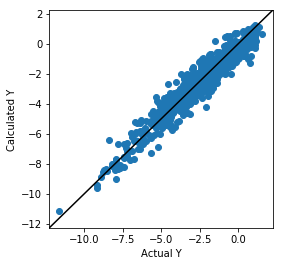

In [9]:
# yy-plot
plt.figure(figsize=figure.figaspect(1))
plt.scatter(ytrain, calculated_ytrain)
YMax = np.max(np.array([np.array(ytrain), calculated_ytrain]))
YMin = np.min(np.array([np.array(ytrain), calculated_ytrain]))
plt.plot([YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin)],
         [YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin)], 'k-')
plt.ylim(YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin))
plt.xlim(YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin))
plt.xlabel('Actual Y')
plt.ylabel('Calculated Y')
plt.show()

In [10]:
# estimated_y in cross-validation
estimated_y_in_cv = np.ndarray.flatten(
    model_selection.cross_val_predict(regression_model, autoscaled_Xtrain, autoscaled_ytrain, cv=fold_number))
if do_autoscaling:
    estimated_y_in_cv = estimated_y_in_cv * ytrain.std(ddof=1) + ytrain.mean()

# r2cv, RMSEcv, MAEcv
print('r2cv: {0}'.format(float(1 - sum((ytrain - estimated_y_in_cv) ** 2) / sum((ytrain - ytrain.mean()) ** 2))))
print('RMSEcv: {0}'.format(float((sum((ytrain - estimated_y_in_cv) ** 2) / len(ytrain)) ** 0.5)))
print('MAEcv: {0}'.format(float(sum(abs(ytrain - estimated_y_in_cv)) / len(ytrain))))

r2cv: 0.7426738858402522
RMSEcv: 1.0410042381988924
MAEcv: 0.8259863430992594


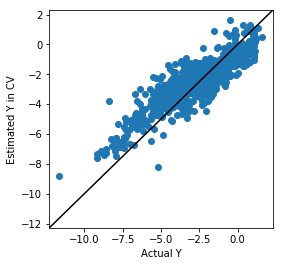

In [11]:
# yy-plot
plt.figure(figsize=figure.figaspect(1))
plt.scatter(ytrain, estimated_y_in_cv)
YMax = np.max(np.array([np.array(ytrain), estimated_y_in_cv]))
YMin = np.min(np.array([np.array(ytrain), estimated_y_in_cv]))
plt.plot([YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin)],
         [YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin)], 'k-')
plt.ylim(YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin))
plt.xlim(YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin))
plt.xlabel('Actual Y')
plt.ylabel('Estimated Y in CV')
plt.show()

r2p: 0.8912297601735731
RMSEp: 0.6569701688350569
MAEp: 0.4945366564049153


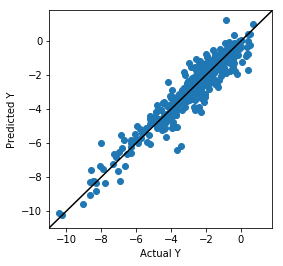

In [12]:
# standard regression coefficients
# standard_regression_coefficients = regression_model.coef_
# standard_regression_coefficients = pd.DataFrame(standard_regression_coefficients)
# standard_regression_coefficients.index = Xtrain.columns
# standard_regression_coefficients.columns = ['standard regression coefficient']
# standard_regression_coefficients.to_csv( 'standard_regression_coefficients.csv' )

# prediction
if raw_Xtest.shape[0]:
    predicted_ytest = np.ndarray.flatten(regression_model.predict(autoscaled_Xtest))
    if do_autoscaling:
        predicted_ytest = predicted_ytest * ytrain.std(ddof=1) + ytrain.mean()
    # r2p, RMSEp, MAEp
    print('r2p: {0}'.format(float(1 - sum((ytest - predicted_ytest) ** 2) / sum((ytest - ytest.mean()) ** 2))))
    print('RMSEp: {0}'.format(float((sum((ytest - predicted_ytest) ** 2) / len(ytest)) ** 0.5)))
    print('MAEp: {0}'.format(float(sum(abs(ytest - predicted_ytest)) / len(ytest))))
    # yy-plot
    plt.figure(figsize=figure.figaspect(1))
    plt.scatter(ytest, predicted_ytest)
    YMax = np.max(np.array([np.array(ytest), predicted_ytest]))
    YMin = np.min(np.array([np.array(ytest), predicted_ytest]))
    plt.plot([YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin)],
             [YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin)], 'k-')
    plt.ylim(YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin))
    plt.xlim(YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin))
    plt.xlabel('Actual Y')
    plt.ylabel('Predicted Y')
    plt.show()
